# Import all necessary library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import yaml

In [2]:
config_path = "../config/config.yaml"

def load_config():

    '''
    this function is to load config file
    '''

    try:

        with open(config_path, "r") as f:

            config = yaml.safe_load(f)

    except FileNotFoundError:

        return "Config file not found!"

    return config

# Data Collection

Dataset House-Price sudah terbagi menjadi set Training dan set Testing. Pada course ini, hanya digunakan set Training saja.

## Ambil alamat penyimpanan file dataset dari file config yang sudah didefinisikan

In [3]:
# load config file that contains raw dataset path
config = load_config()

# grab raw dataset path
raw_path = config["raw_dataset_path"]

## Load dataset

In [4]:
# remember this dataset is alrady splitted. we only load the train set
train = pd.read_csv(raw_path)

# print header of dataframe
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


# Data Exploration and Prerocessing

Outline:
* Check data type and match with definition given by data source
* Separate columns based on definition
* Check missing value and handle it
* Check outlier and handle it

## Data type

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

combining information from the data definition, we can group all columns by their data type

In [6]:
# int64 columns
int_columns = ["OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", 
"FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars"]

# datetime columns
datetime_columns = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]
# the fact is columns only contain year or month, we can treat this as integer later

# float64 columns
float_columns = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1",
"BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
"GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
"3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]

# ordinal columns (dtype is equal to object/categoric, but these are actually ordinal features)
ordinal_columns = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
"BsmtFinType2", "HeatingQC", "CentralAir", "KitchenQual", "GarageFinish",
"GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence"]

# categorical columns
obj_columns = ["MSSubClass", "MSZoning", "Alley", "Street", "LotShape", "LandContour",
"Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", 
"Condition2", "BldgType", "HouseStyle", "OverallQual", "RoofStyle",
"RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual",
"ExterCond", "Foundation", "Heating", "Electrical", "Functional", "FireplaceQu", 
"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

# target column
target_column = ["SalePrice"]

note that datetime_columns only contain year and month separately. We can treat this as int column

## Missing Value

### Check Missing Value

In [7]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = train.isnull().sum()[train.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_train = pd.DataFrame({'NaN_count': missing, 'NaN_percentage': missing / len(train)}).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_train

,NaN_count,NaN_percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Berdasarkan sumber data asli (baca: [house_price_source](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)), setiap kolom pada data telah didefinisikan. Sehingga, berdasarkan definisi tersebut, terdapat beberapa kolom yang nilai NA (*missing value*) sebenarnya bukan *missing value* melainkan memiliki arti **Tidak ada** (selanjutnya disebut *legit NA*)

Berdasarkan sumber tersebut, informasi terkait NA yang dikumpulkan adalah sebagai berikut:

* NA value in "PoolQC" column means **no pool**. It doesn't mean **missing value**

* NA value in "MiscFeature" column means **no additional house feature**. It doesn't mean **missing value**

* NA value in "Alley" column means **no alley connected to house**. It doesn't mean **missing value**

* NA value in "Fence" column means **the house has no fence**. It doesn't mean **missing value**

* NA value in "Fireplaces" column means **the house has no fireplace**. It doesn't mean **missing value**

* NA value in "FireplaceQu" column means **No Fire Place**. It doesn't mean **missing value**

* no explanation about NA value for "LotFrontage". Thus, we enact this as **missing value**

* NA value in "GarageType" column means **the house has no garage**. It doesn't mean **missing value**

* since the house with **no garage** would also has no information about "GarageFinish", "GarageYrBlt, "GarageQual", and "GarageCond", the NA value should not considered as **missing value**.

* NA value in "BsmtQual", "BsmtFinType2", "BsmtinType1", "BsmtCond", and "BsmtExposure" columns means **the house has no garage**. It doesn't mean **missing value**.

* NA value in "MasVnrType" and "VasVnrArea" columns means **the house has no masonry veneer**. It doesn't mean **missing value**

* no explanation about NA value for "Electrical". Thus, we enact this as **missing value**

sehingga, penanganan nilai NA pada kolom *legit NA* akan berbeda dengan kolom NA *missing value*

### Missing Value Handling

berdasarkan informasi di atas, ambil kolom-kolim *legit NA* agar dapat ditangani

In [8]:
# specify columns with legit na values
legit_na_values_columns = ["MasVnrArea", "MasVnrType", "BsmtExposure", "BsmtCond", "BsmtFinType1", 
                          "BsmtFinType2", "BsmtQual", "GarageCond", "GarageQual", 
                          "GarageFinish", "GarageType", "Fireplaces", "Fence", "Alley", "MiscFeature", 
                          "PoolQC", "GarageYrBlt", "FireplaceQu"]

# print how many columns with legit na values
print(f'number of columns with legit NA values: {len(legit_na_values_columns)}')

number of columns with legit NA values: 18


untuk mengetahui metode penanganan yang tepat, kita harus memisahkan kolom dengan tipe data numerik dan tipe data kategorik

In [9]:
# specify columns with numeric dtype
num_legit_na = [i for i in train[legit_na_values_columns].columns if train[i].dtype in ["int", "float"]]

# print how many columns with legit na values (numeric)
print(f'number of numeric columns with legit NA values: {len(num_legit_na)}')

number of numeric columns with legit NA values: 3


In [10]:
# specify columns with categoric dtype
cat_legit_na = [i for i in train[legit_na_values_columns].columns if train[i].dtype=="object"]

# print how many columns with legit na values (numeric)
print(f'number of categorical columns with legit NA values: {len(cat_legit_na)}')

number of categorical columns with legit NA values: 15


untuk mencegah terjadi sesuatu yang tidak diingingkan, backup dataset asli

In [11]:
# copy the initial dataset to backup if any incident happens
train_handled = train.copy()

#### Handling NA values in numeric columns by imputing 0

In [12]:
# we know that GarageYrBlt is of type datetime, best way to handle it is by removing it.
num_legit_na.remove("GarageYrBlt")

In [13]:
# handle missing value in datetime column by removing it
train_handled.dropna(subset=["GarageYrBlt"], inplace=True)

In [14]:
# fill all legit na values in numeric columns with 0

train_handled[num_legit_na] = train_handled[num_legit_na].fillna(0)

In [15]:
# check the filling result

train_handled[num_legit_na].isna().sum()

MasVnrArea    0
Fireplaces    0
dtype: int64

In [16]:
# check na dropping
train_handled["GarageYrBlt"].isna().sum()

0

**Na values replacement is successfully!**

#### Handling NA values in categoric columns by imputing "not_exist"

In [17]:
# fill legit na values in cat columns with value "not_exist"

train_handled[cat_legit_na] = train_handled[cat_legit_na].fillna("not_exist")

In [18]:
# check the filling result

train_handled[cat_legit_na].isna().sum()

MasVnrType      0
BsmtExposure    0
BsmtCond        0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
GarageCond      0
GarageQual      0
GarageFinish    0
GarageType      0
Fence           0
Alley           0
MiscFeature     0
PoolQC          0
FireplaceQu     0
dtype: int64

**NA Values replacement successfully!**

#### merge handled NA values dataframe with original one

In [19]:
# merge the handled missing value dataframe with original one
train_merged = pd.merge(train, train_handled, how="right").copy()
train_merged

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1456,60,RL,62.0,7917,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,8,2007,WD,Normal,175000
1375,1457,20,RL,85.0,13175,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,MnPrv,not_exist,0,2,2010,WD,Normal,210000
1376,1458,70,RL,66.0,9042,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1377,1459,20,RL,68.0,9717,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,4,2010,WD,Normal,142125


check again NA in dataframe, there should only real missing value columns left

In [20]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = train_merged.isnull().sum()[train_merged.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_train = pd.DataFrame({'NaN_count': missing, 'NaN_percentage': missing / len(train)}).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_train

,NaN_count,NaN_percentage
LotFrontage,252,0.172603
Electrical,1,0.000685


**only real missing value left!**

#### Handling real missing value

in order to choose right imputation method. we need to analyze some of the feature intrinsic information, such as:
* feature mean,
* feature median,
* feature data shape,

**LotFrontage**

In [21]:
# descriptive statistics of LotFrontage
train_merged.LotFrontage.describe()

count    1127.000000
mean       70.683230
std        24.261598
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

we can see that the distribution of data is quiet good.

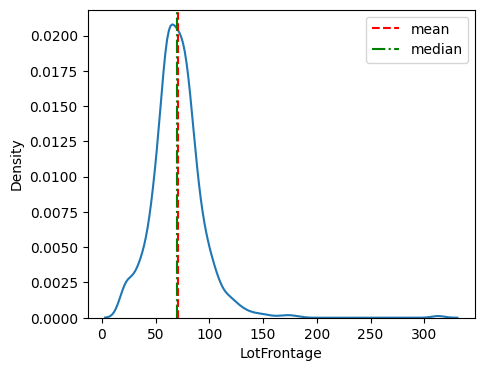

In [22]:
# set pyplote figure, and define the pre-defined size
plt.figure(figsize=(5,4))

# plot seaborn kdeplot for LotFrontage
sns.kdeplot(data=train_merged, x="LotFrontage")

# draw vertical line to describe the mean value
plt.axvline(x=train_merged.LotFrontage.mean(), color="r", linestyle="--", label="mean")

# draw vertical line to describe the median value
plt.axvline(x=train_merged.LotFrontage.median(), color="g", linestyle="-.", label="median")

# show the legend
plt.legend()

# show the whole graph
plt.show()

we can see that the median and the mean value is quiet near. But as the distribution is quiete skew to the right, we use **median** for the imputation of **LotFrontage** so that it could be robust to skewness

**Imputing Missing Value for LotFrontage** 

In [23]:
# fill missing value using median value
train_merged["LotFrontage"] = train_merged["LotFrontage"].fillna(train_merged.LotFrontage.median())

In [24]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = train_merged.isnull().sum()[train_merged.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_train = pd.DataFrame({'NaN_count': missing, 'NaN_percentage': missing / len(train)}).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_train

,NaN_count,NaN_percentage
Electrical,1,0.000685


**Missing value imputation successful!**

next, as missing value in Electrical is only one observation. Then, we consider this as too small so we handle this by removing the observation that contain NA value.

**Drop NA in Electrical**

In [25]:
train_merged.dropna(subset=["Electrical"], inplace=True)

In [26]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = train_merged.isnull().sum()[train_merged.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_train = pd.DataFrame({'NaN_count': missing, 'NaN_percentage': missing / len(train)}).sort_values(by = 'NaN_percentage', ascending = False)

# print the missin
missing_train

,NaN_count,NaN_percentage


**as we can see, no missing value left in our training dataset. Hence, missing value handling step is complete!**

## Detect and Handle Outlier

Terkait outlier, terdapat dua task yang tidak dapat dipisahkan yakni:
* Outlier Detection, dan
* Outlier Handling

kedua task tersebut memiliki metode nya masing-masing.

untuk **Outlier Detection** kita bisa memilih menggunakan berbagai metode yakni:
* IQR Filter (quantitative)
* Z-Score Filter (quantitative)
* Box-Plot (qualitative)


setelah mendapatkan observasi-observasi yang dianggap *outlier*, selanjutnya melakukan **Outlier Handling** menggunakan salah satu dari metode berikut:
* Trimming/removing outlier --> Membuang baris yang mengandung nilai outlier
* Quantile based flooring and capping --> Membulatkan nilai yang dianggap outlier menjadi nilai kuantil 10 atau kuantil 90
* Mean/median imputation --> Mengganti nilai outlier dengan mean/median dari kolom tempat outlier berada

further readings: [AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

### Mendeteksi outlier menggunakan Box-Plot

In [27]:
# select only numeric columns
colnames = int_columns+float_columns

# reset index
train_merged.reset_index(drop=True, inplace=True)

In [28]:
# minimal subplot rows to make if we want 3 columns
import math
print(math.ceil(len(colnames)/3))

10


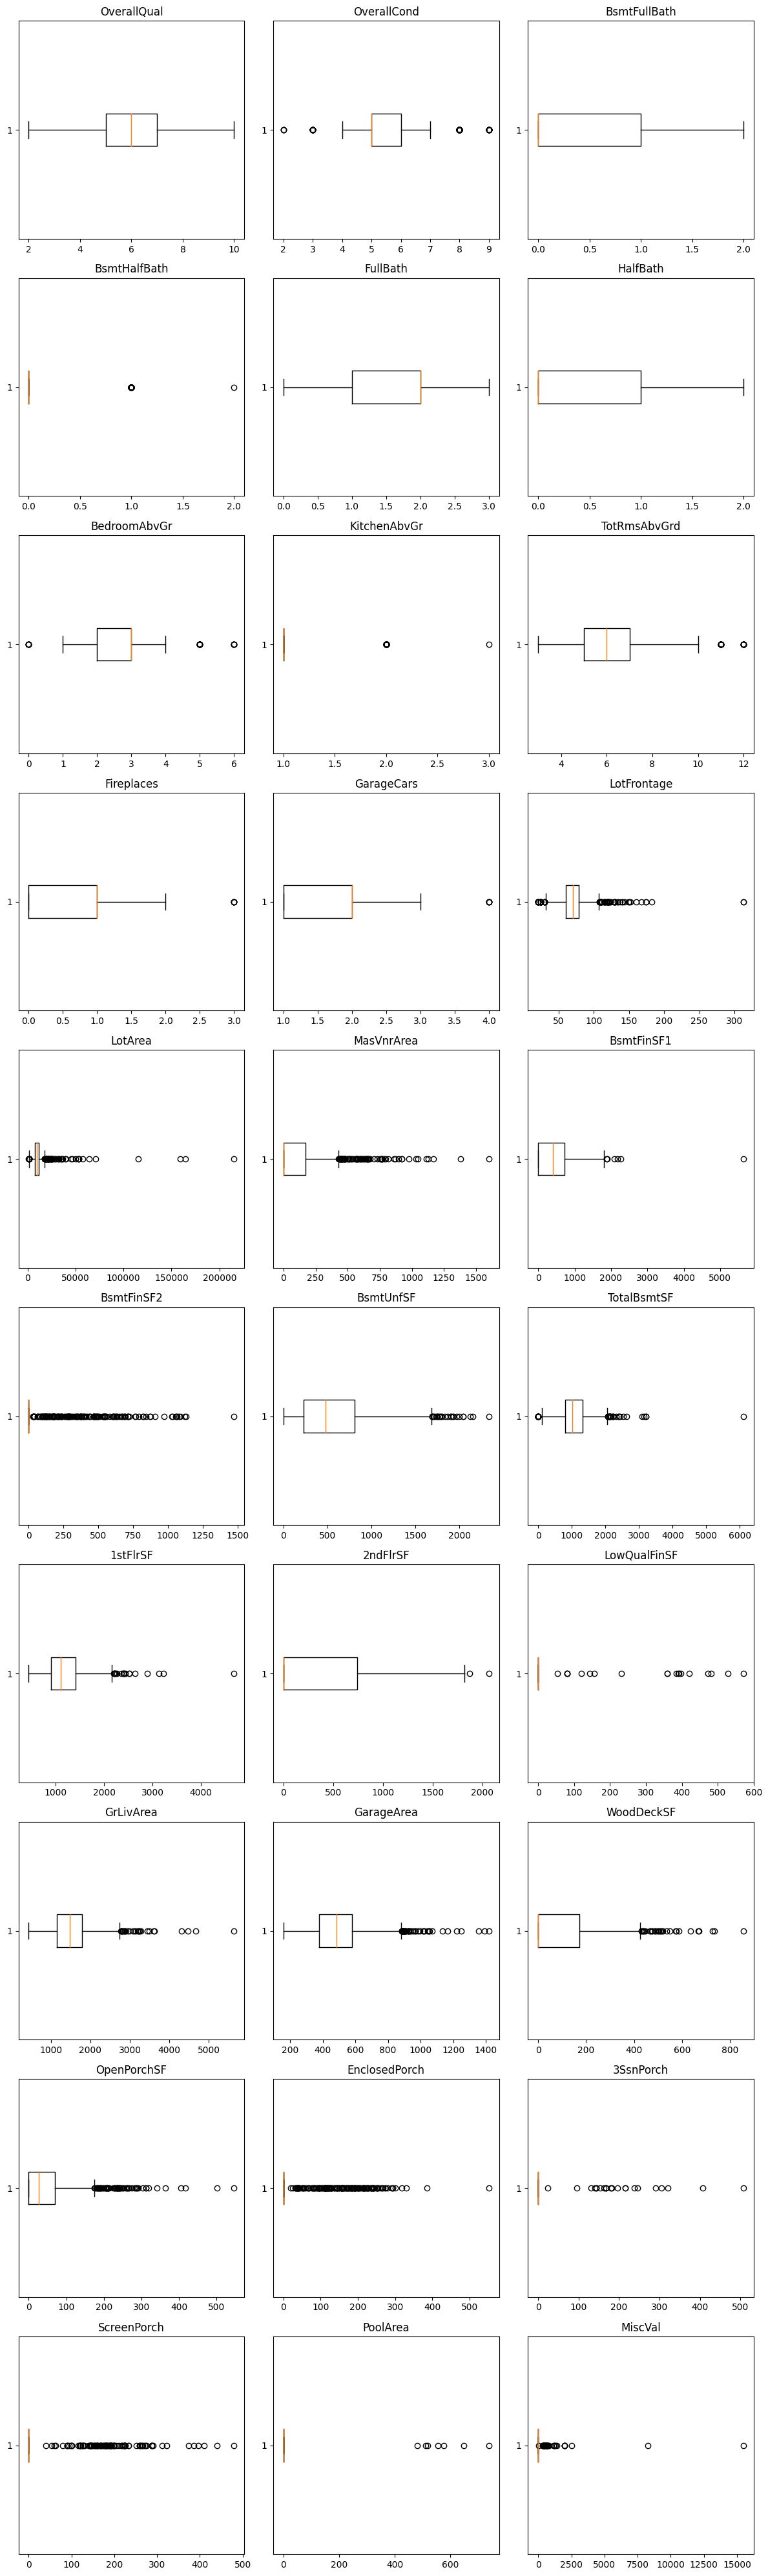

In [29]:
# create subplots with 11x3 grids and size 12x30
fig, ax = plt.subplots(10, 3, figsize=(12,40))

# counter to select colnames
cnt = 0

# loop through the grids
for i in range(11):

    if cnt >= 30:
            break

    for j in range(3):

        if cnt >= 30:
            break
        
        # we use boxplot from pyplot
        ax[i, j].boxplot(train_merged[colnames[cnt]], vert=False)
        ax[i, j].set_title(str(colnames[cnt]), fontdict={'fontsize':12})

        # increment counter
        cnt = cnt+1

# make sure layout is not overlapping
fig.tight_layout()
# show the graphs
fig.show()

from boxplots above, we have extracted some useful informations such as:
* some columns seem to have outliers but actually it's just the range of the data (such as in ordinal). hence we may not treat as outlier. Those columns are:

        - OverallQual
        - OverallCond
    
* other columns (not ordinal) seem to have outliers. But, if look carefully, the value is not as extreme as outlier should be. Some column seems just OK, those are:
       
        - BsmtHalfBath
        - BedroomAbvGr
        - KitchenAbvGr
        - TotRmsAbvGrd
        - Fireplaces
        - GarageCars

* other than above columns, we could take some action to handle the outlier. The columns are:

        - LotFrontage
        - LotArea
        - MasVnrArea
        - BsmtFinSF1
        - BsmtFinSF2
        - BsmtUnfSF
        - TotalBsmtSF
        - 1stFlrSF
        - 2ndFlrSF
        - LowQualFinSF
        - GrLivArea
        - GarageArea
        - WoodDeckSF
        - OpenPorchSF
        - EnclosedPorch
        - 3SsnPorch
        - ScreenPorch
        - PoolArea
        - MiscVal

using boxplot we can only infer that there are outliers in some columns. But, in order to get the exact location of the outlier we are going to use **IQR filter**

### Mendeteksi outlier menggunakan IQR Filter

In [30]:
# function to detect outlier using IQR
def detect_outliers_iqr(data):

    # initialize list that contains the outliers
    outliers = []

    # sort data values
    data = sorted(data)

    # compute the q1
    q1 = np.percentile(data, 25)

    # compute the q3
    q3 = np.percentile(data, 75)

    # compute the IQR
    IQR = q3-q1

    # set the lower bound
    ## note that we can play with value 1.5 to widen or narrow the range
    lwr_bound = q1-(1.5*IQR)

    # set the upper bound
    ## note that we can play with value 1.5 to widen or narrow the range
    upr_bound = q3+(1.5*IQR)

    # print computed lower and upper bound of a particular column
    print("lower:",lwr_bound, "upper:", upr_bound)

    # for each data point, decide whether it falls below lower bound or above upper ground
    for i in data:

        if (i<lwr_bound or i>upr_bound):

            outliers.append(i)

    return outliers

In [31]:
# put outlier columns (inferred from boxplot analysis above) in a list
outlier_columns = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
"2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
"PoolArea", "MiscVal"]

In [32]:
for col in outlier_columns:

    outlier = detect_outliers_iqr(train_merged[col])

    print("number of outliers in column", f"'{str(col)}'", "is", len(outlier))
    print()

lower: 31.5 upper: 107.5
number of outliers in column 'LotFrontage' is 98

lower: 1782.125 upper: 17671.125
number of outliers in column 'LotArea' is 79

lower: -256.125 upper: 426.875
number of outliers in column 'MasVnrArea' is 86

lower: -1098.0 upper: 1830.0
number of outliers in column 'BsmtFinSF1' is 6

lower: 0.0 upper: 0.0
number of outliers in column 'BsmtFinSF2' is 163

lower: -647.75 upper: 1686.25
number of outliers in column 'BsmtUnfSF' is 26

lower: 54.625 upper: 2069.625
number of outliers in column 'TotalBsmtSF' is 54

lower: 114.0 upper: 2194.0
number of outliers in column '1stFlrSF' is 18

lower: -1108.125 upper: 1846.875
number of outliers in column '2ndFlrSF' is 2

lower: 0.0 upper: 0.0
number of outliers in column 'LowQualFinSF' is 19

lower: 200.0 upper: 2744.0
number of outliers in column 'GrLivArea' is 29

lower: 78.5 upper: 882.5
number of outliers in column 'GarageArea' is 46

lower: -256.5 upper: 427.5
number of outliers in column 'WoodDeckSF' is 30

lower: -

Information from detection using IQR above:
* Some columns have lower and upper bound equal to 0. This doesn't make sense. Hence, we don't handle the outlier (as it may be not a noise). The columns are:

        - "BsmtFinSF2"
        - "LowQualFinSF"
        - "EnclosedPorch"
        - "3SsnPorch"
        - "ScreenPorch"
        - "PoolArea"
        - "MiscVal"

In [33]:
# remove columns with lower and upper bound equal 0
outlier_columns=[out for out in outlier_columns if out not in ["BsmtFinSF2", "LowQualFinSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]]
outlier_columns

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

In [34]:
len(outlier_columns)

12

look again the boxplot before handling the outliers

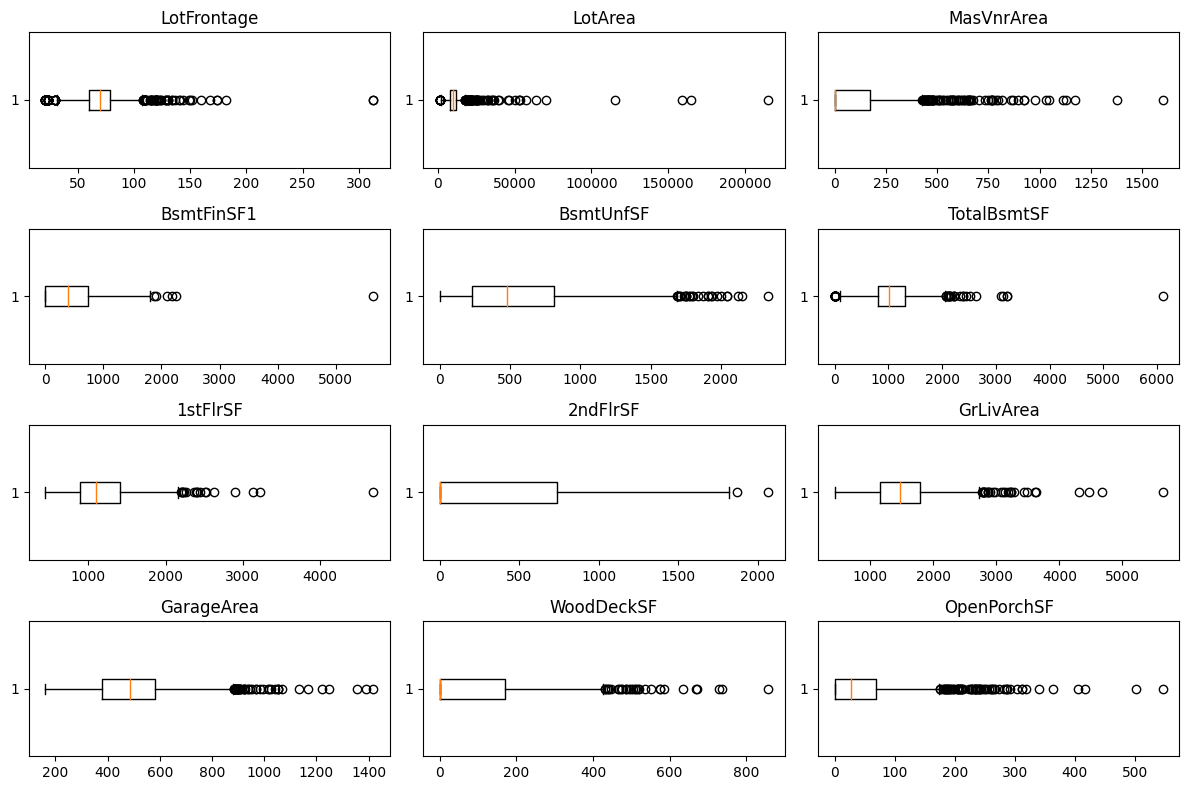

In [35]:
# create subplots with 4x3 grids and size 12x30
fig, ax = plt.subplots(4, 3, figsize=(12,8))

# counter to select outlier_columns
cnt = 0

# loop through the grids
for i in range(4):

    if cnt >= 12:
            break

    for j in range(3):

        if cnt >= 12:
            break
        
        # we use boxplot from pyplot
        ax[i, j].boxplot(train_merged[outlier_columns[cnt]], vert=False)
        ax[i, j].set_title(str(outlier_columns[cnt]), fontdict={'fontsize':12})

        # increment counter
        cnt = cnt+1

# make sure layout is not overlapping
fig.tight_layout()
# show the graphs
fig.show()

### Handle outlier using capping method

capping detected outliers is a handful approach to handle our outliers since it isn't removing values (since it may be useful information).

capping comes in two approach:
* using IQR upper and lower bound
* using fixed quantile

for this task, we will use **fixed quantile** aproach.

**Fixed quantile** approach values as outliers if they are less than or more than the values for 97% of all the records in your dataset. In such cases you can use the `quantile()` method of the Pandas dataframe and pass it thresholds for lower and upper limits.

For instance, a threshold value of 0.03 for the `quantile()` method will find the values that are less than 97% of all the records in the dataset. Where as a threshold value of 97% returns values that are greater than 97% of the records.

further reading: [wellsr](https://wellsr.com/python/outlier-data-handling-with-python/)

In [36]:
import copy
train_capped = copy.deepcopy(train_merged)

In [37]:
def capping_outlier(col):

    lwr_limit = train_capped[col].quantile(0.03)
    upr_limit = train_capped[col].quantile(0.97)

    print(str(col).upper())
    print("lwr:", lwr_limit, "upr:", upr_limit)
    print()

    train_capped[col] = np.where(train_capped[col]> upr_limit, upr_limit, 
                                        np.where(train_capped[col]< lwr_limit, lwr_limit, train_capped[col]))

In [38]:
for col in outlier_columns:

    capping_outlier(col)

LOTFRONTAGE
lwr: 30.61999999999999 upr: 114.0

LOTAREA
lwr: 2603.16 upr: 21750.0

MASVNRAREA
lwr: 0.0 upr: 582.4500000000003

BSMTFINSF1
lwr: 0.0 upr: 1386.69

BSMTUNFSF
lwr: 0.0 upr: 1592.1400000000003

TOTALBSMTSF
lwr: 384.0 upr: 1924.7600000000002

1STFLRSF
lwr: 630.0 upr: 1997.5200000000004

2NDFLRSF
lwr: 0.0 upr: 1254.0

GRLIVAREA
lwr: 833.62 upr: 2633.69

GARAGEAREA
lwr: 220.0 upr: 888.0

WOODDECKSF
lwr: 0.0 upr: 393.3800000000001

OPENPORCHSF
lwr: 0.0 upr: 213.69000000000005



see boxplot after outlier handling

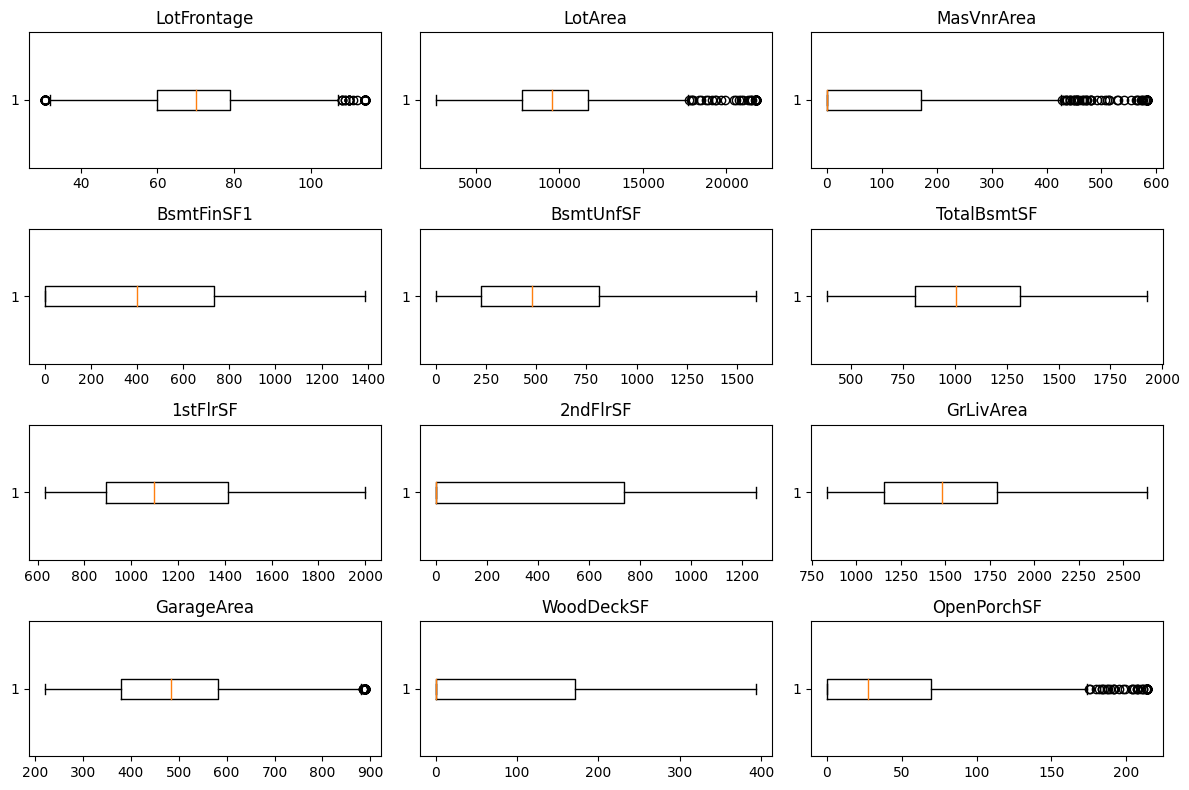

In [39]:
# create subplots with 4x3 grids and size 12x30
fig, ax = plt.subplots(4, 3, figsize=(12,8))

# counter to select outlier_columns
cnt = 0

# loop through the grids
for i in range(4):

    if cnt >= 12:
            break

    for j in range(3):

        if cnt >= 12:
            break
        
        # we use boxplot from pyplot
        ax[i, j].boxplot(train_capped[outlier_columns[cnt]], vert=False)
        ax[i, j].set_title(str(outlier_columns[cnt]), fontdict={'fontsize':12})

        # increment counter
        cnt = cnt+1

# make sure layout is not overlapping
fig.tight_layout()
# show the graphs
fig.show()

**Outlier Handling Successfully!**

# Feature Engineering

## Categorical columns: One Hot Encoder

Many of machine learning models only take numerics as input. Thus, we have to encode all categorical features in our dataset

One of the method to encode categorics into numerics is by using **One Hot Encoder** (OHE).

OHE make new columns based on levels in each column. if an observation contains a particular level, the column of which that level encodes will be filled with 1, else 0.

further readings: [Towards Data Science](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)

at earlier step, we collect categorical columns in a list `obj_columns`

In [40]:
# initialize OHE
ohe = OneHotEncoder(handle_unknown="ignore")

In [41]:
# copy dataset
train_ohe = copy.deepcopy(train_capped)

# fit the OHE to categorical columns
ohe.fit(train_ohe[obj_columns])


OneHotEncoder(handle_unknown='ignore')

In [42]:
# transform categorical columns
ohe_cat = ohe.transform(train_ohe[obj_columns])

In [43]:
# turn into pd dataframe
ohe_cat = pd.DataFrame(ohe_cat.toarray(), columns=ohe.get_feature_names_out())
ohe_cat

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1375,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1376,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
# join ohe columns to original dataset
train_ohe = train_ohe.join(ohe_cat)
train_ohe

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,RL,65.0,8450.0,Pave,not_exist,Reg,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,RL,80.0,9600.0,Pave,not_exist,Reg,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,RL,68.0,11250.0,Pave,not_exist,IR1,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,RL,60.0,9550.0,Pave,not_exist,IR1,Lvl,AllPub,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,RL,84.0,14260.0,Pave,not_exist,IR1,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,1456,60,RL,62.0,7917.0,Pave,not_exist,Reg,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1374,1457,20,RL,85.0,13175.0,Pave,not_exist,Reg,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1375,1458,70,RL,66.0,9042.0,Pave,not_exist,Reg,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1376,1459,20,RL,68.0,9717.0,Pave,not_exist,Reg,Lvl,AllPub,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
# drop unencoded columns
train_ohe.drop(obj_columns, axis=1, inplace=True)
train_ohe

,Id,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450.0,5,2003,2003,196.0,Gd,TA,No,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,80.0,9600.0,8,1976,1976,0.0,Gd,TA,Gd,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,68.0,11250.0,5,2001,2002,162.0,Gd,TA,Mn,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,60.0,9550.0,5,1915,1970,0.0,TA,Gd,No,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,84.0,14260.0,5,2000,2000,350.0,Gd,TA,Av,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,1456,62.0,7917.0,5,1999,2000,0.0,Gd,TA,No,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1374,1457,85.0,13175.0,6,1978,1988,119.0,Gd,TA,No,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1375,1458,66.0,9042.0,9,1941,2006,0.0,TA,Gd,No,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1376,1459,68.0,9717.0,6,1950,1996,0.0,TA,TA,Mn,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


**OHE successfully!**

## Ordinal columns: Label Encoding

Some of our columns contain ordinal value. This value better encoded using label encoding. The categorical labels inside the column imply ranking and could be represented as integer number.

ref: [Towards Data Science](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)

In [46]:
# look again the ordinal columns
train_ohe[ordinal_columns].describe().T

,count,unique,top,freq
BsmtQual,1378,5,Gd,600
BsmtCond,1378,5,TA,1246
BsmtExposure,1378,5,No,895
BsmtFinType1,1378,7,GLQ,408
BsmtFinType2,1378,7,Unf,1185
HeatingQC,1378,5,Ex,720
CentralAir,1378,2,Y,1309
KitchenQual,1378,4,TA,676
GarageFinish,1378,3,Unf,605
GarageQual,1378,5,TA,1310


we have to construct value mapper based on data definition

as like we've seen before, there are some ordinal value groups.
to simplify encoding, we will encode them by common ordinal values

In [100]:
# copy dataset
train_le = copy.deepcopy(train_ohe)

In [101]:
# six level of ordinal
six_order = ["BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "GarageQual",
"GarageCond", "PoolQC"]
six_order_mapper = {
    "not_exist": 0,
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}

# exposure level ordinal
exp = ["BsmtExposure"]
exp_mapper = {
    "not_exist": 0,
    "No": 1,
    "Mn": 2,
    "Av": 3,
    "Gd": 4,
}

# BsmtFin level ordinal
bsmt_fin = ["BsmtFinType1", "BsmtFinType2"]
bsmt_fin_mapper = {
    "GLQ": 6,
    "ALQ": 5,
    "BLQ": 4,
    "Rec": 3,
    "LwQ": 2,
    "Unf": 1,
    "not_exist": 0,
}

# CentralAir level ordinal
cnt_air = ["CentralAir"]
cnt_air_mapper = {
    "N": 0,
    "Y": 1,
}

# GarageFinisih level ordinal
grg_finish = ["GarageFinish"]
grg_finish_mapper = {
    "not_exist": 0,
    "Unf": 1,
    "RFn": 2,
    "Fin": 3,
}

# PavedDrive level ordinal
pvd_drive = ["PavedDrive"]
pvd_drive_mapper = {
    "N": 0,
    "P": 1,
    "Y": 2,
}

# Fence level ordinal
fence = ["Fence"]
fence_mapper = {
    "not_exist": 0,
    "MnWw": 1,
    "GdWo": 2,
    "MnPrv": 3,
    "GdPrv": 4,
}

ordinal_list = [six_order, exp, bsmt_fin, cnt_air, grg_finish, pvd_drive, fence]
mapper_list = [six_order_mapper, exp_mapper, bsmt_fin_mapper, cnt_air_mapper, grg_finish_mapper, pvd_drive_mapper, fence_mapper]

In [65]:
# are all ordinal column mapper have been defined?

len(six_order+exp+bsmt_fin+cnt_air+grg_finish+pvd_drive+fence) == len(ordinal_columns)

True

In [103]:
# this function run the label encoding task
def le_mapper(col, map):

    train_le[col] = train_le[col].replace(map)
    # print(train_le[col])

In [104]:
for col, mapper in zip(ordinal_list, mapper_list):

    le_mapper(col, mapper)

In [106]:
train_le[ordinal_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
BsmtQual,1378.0,3.522496,0.856350,0.0,3.0,4.0,4.0,5.0
BsmtCond,1378.0,2.951379,0.519582,0.0,3.0,3.0,3.0,4.0
BsmtExposure,1378.0,1.645864,1.068184,0.0,1.0,1.0,2.0,4.0
BsmtFinType1,1378.0,3.605225,2.098387,0.0,1.0,4.0,6.0,6.0
BsmtFinType2,1378.0,1.256168,0.889939,0.0,1.0,1.0,1.0,6.0
HeatingQC,1378.0,4.174891,0.950042,1.0,3.0,5.0,5.0,5.0
CentralAir,1378.0,0.949927,0.218174,0.0,1.0,1.0,1.0,1.0
KitchenQual,1378.0,3.545718,0.652140,2.0,3.0,3.0,4.0,5.0
GarageFinish,1378.0,1.815675,0.812565,1.0,1.0,2.0,3.0,3.0
GarageQual,1378.0,2.975327,0.248687,1.0,3.0,3.0,3.0,5.0


**Label encoding succesfully!**

In [109]:
X = train_le.drop(["Id", "SalePrice"], axis=1)
y = train_le.SalePrice

# Modelling just try

In [111]:
from sklearn.ensemble import RandomForestRegressor

In [112]:
rf = RandomForestRegressor()

In [113]:
rf.fit(X, y)

RandomForestRegressor()

In [118]:
y_pred = rf.predict(X)

In [123]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

print("MAE:",mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("R2:",r2_score(y, y_pred))


MAE: 6537.637227866473
RMSE: 11546.018636026658
R2: 0.9786516644788024


**base model predict on training data show great result**

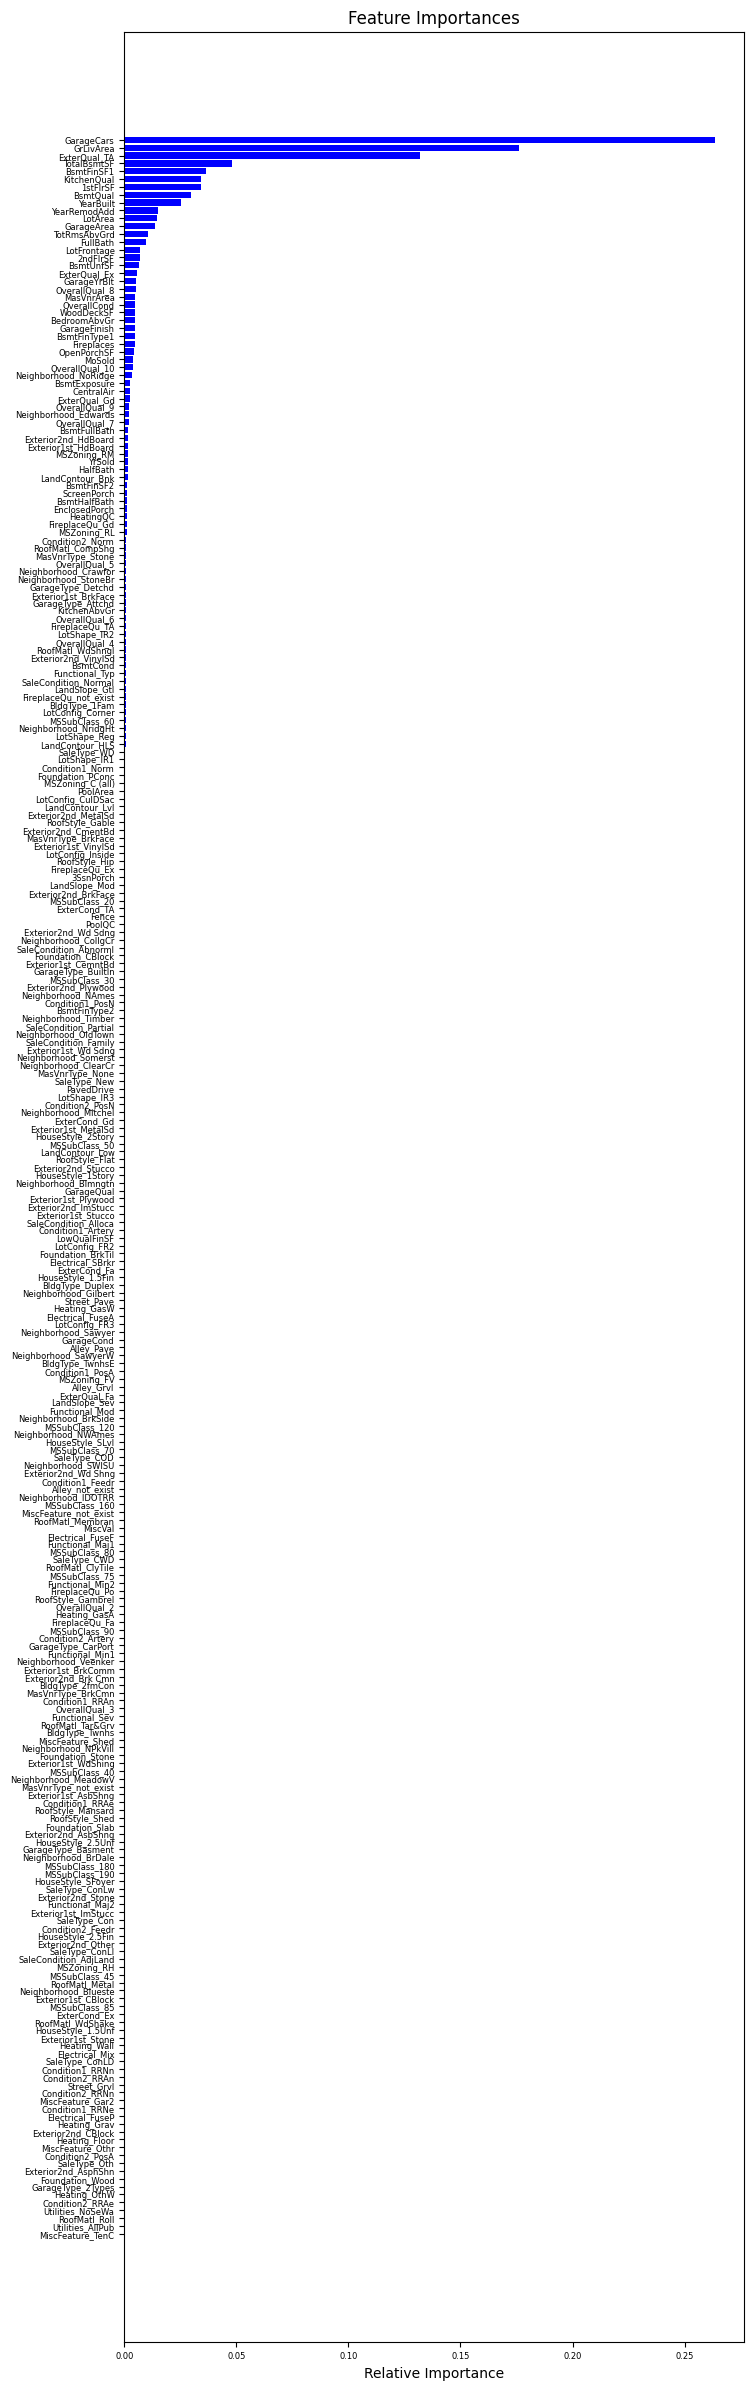

In [138]:
features = list(X.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.show()